# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Импорт библиотек

In [29]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm

import os

from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
# добавим константу, так как ее будем менять в процессе
random_state = 40

## Откройте и изучите файл

In [4]:
path1 = '../data/users_behavior.csv'
path2 = '/datasets/users_behavior.csv'

if os.path.exists(path1):
    users_behavior_df = pd.read_csv(path1)
elif os.path.exists(path2):
    users_behavior_df = pd.read_csv(path2)
else:
    print('OOoops!')

users_behavior_df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [5]:
users_behavior_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Отлично, пропусков нет. Значит, все гуд. 
___

Все же проведу некоторую предобработку - нормализую значения. Так же модели работать будут лучше? 

In [6]:
target = users_behavior_df['is_ultra']
features = users_behavior_df.drop(['is_ultra'], axis=1)

print(target.shape)
print(features.shape)

(3214,)
(3214, 4)


Проведем среднюю нормализацию. Кажется, она упрощает вычисления для моделей. Но это не точно. 

In [7]:
# features_normalized = (features - features.mean()) / features.std()
# features_normalized.head()

In [8]:
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)
features_normalized = pd.DataFrame(features_normalized, columns=features.columns)
features_normalized.head()

,calls,minutes,messages,mb_used
0,-0.693291,-0.538554,1.237282,0.357704
1,0.660858,0.334883,0.490244,0.725157
2,0.420121,0.125574,1.320287,0.508967
3,1.292794,1.310352,1.181946,-1.158590
4,0.089106,-0.083011,-1.031502,-0.357331


## Разбейте данные на выборки

In [9]:
features_train, features_test, target_train, target_test = train_test_split(
                                                                            features_normalized,
                                                                            target, 
                                                                            random_state=random_state, 
                                                                            test_size=0.25,
                                                                            stratify=target, #стратифицируем по кол-ву классов
                                                                            shuffle=True #встряхнем выборку
                                                                           )

In [10]:
# _np means not preproccessed 
features_train_np, features_test_np, target_train_np, target_test_np = train_test_split(
                                                                            features,
                                                                            target, 
                                                                            random_state=random_state, 
                                                                            test_size=0.25,
                                                                            stratify=target, #стратифицируем по кол-ву классов
                                                                            shuffle=True #встряхнем выборку
                                                                           )

# Сравнение моделей

## Логрег

In [11]:
parametrs    = {
                'max_iter': np.arange(30, 50),
               }

logreg = LogisticRegression(random_state=random_state,)
logreg_grid = GridSearchCV(logreg, parametrs, cv=4)

logreg_grid.fit(features_train, target_train);

In [12]:
parametrs_np    = {
                'max_iter': np.arange(120, 200),
               }
logreg_np = LogisticRegression(random_state=random_state)
logreg_grid_np = GridSearchCV(logreg_np, parametrs_np, cv=4)

logreg_grid_np.fit(features_train_np, target_train_np);

In [13]:
def ez_plot(grid, ar=np.arange(50, 100), label='model'):
    plt.plot(ar, grid.cv_results_['mean_test_score'], 'o-', label=label)
    plt.xlabel('mean cv score')
    plt.ylabel('max_iter')
    plt.title('gridsearch score')

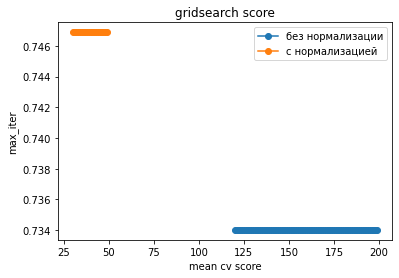

In [14]:
ez_plot(logreg_grid_np, ar=parametrs_np['max_iter'], label='без нормализации')
ez_plot(logreg_grid, ar=parametrs['max_iter'], label='с нормализацией')
plt.legend();

In [15]:
final_logreg_model = logreg_grid.best_estimator_
logreg_grid.best_params_

{'max_iter': 30}

In [16]:
print(f' Скор с нормализацией: {logreg_grid.best_score_}')
print(f' Скор без нормализации: {logreg_grid_np.best_score_}')

 Скор с нормализацией: 0.74688916987598
 Скор без нормализации: 0.7340154157231561


Здесь скор стабильный вне зависимости от количества итераций. Видимо, градиентный спуск нашел свой локальный минимум и сидит там.

## Дерево решений

In [17]:
params = {'max_depth': np.arange(5, 25),}

tree_model = DecisionTreeClassifier(random_state=random_state)
tree_grid  = GridSearchCV(tree_model, params, cv=4)

tree_grid.fit(features_train, target_train);

Теперь построим график скора в зависмости от параметра.

Text(0.5, 1.0, 'gridsearch score')

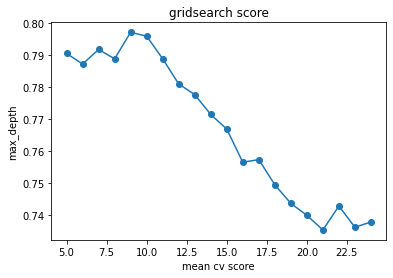

In [18]:
plt.plot(np.arange(5, 25), tree_grid.cv_results_['mean_test_score'], 'o-')
plt.xlabel('mean cv score')
plt.ylabel('max_depth')
plt.title('gridsearch score')

In [19]:
final_tree_model = tree_grid.best_estimator_
tree_grid.best_params_

{'max_depth': 9}

In [20]:
tree_grid.best_score_

0.7970880646600882

Лучший скор представвлен выше. Возможно, он изменится, если изменить рандом стейт. Но, в любом случае, идем дальше.

## Лес

In [21]:
%%time
params = {
    'max_depth': np.arange(5, 10),
    'n_estimators': np.arange(10, 100)
         }

forest_model = RandomForestClassifier(random_state=random_state)
forest_grid  = GridSearchCV(forest_model, params, cv=4)

forest_grid.fit(features_train, target_train);

CPU times: user 4min 24s, sys: 2.07 s, total: 4min 27s
Wall time: 4min 27s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=40),
             param_grid={'max_depth': array([5, 6, 7, 8, 9]),
                         'n_estimators': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94,
       95, 96, 97, 98, 99])})

In [22]:
final_forest_model = forest_grid.best_estimator_
forest_grid.best_params_

{'max_depth': 9, 'n_estimators': 15}

Скор уже выше и, вероятно, модель не переобучилась на данных - каждый раз мы ее прогоняли по кросс-валидации. Но и это не панацея. Модель может подстроиться под имеющийся датасет. Спасет только тестовая проверка.

## Проверьте модель на тестовой выборке

In [23]:
print('Скор рандомного леса на тестовой выборке:')
print(final_forest_model.score(features_test, target_test))
print('Скор логрега на тестовой выборке:')
print(final_logreg_model.score(features_test, target_test))
print('Скор дерева на тестовой выборке:')
print(final_tree_model.score(features_test, target_test))


Скор рандомного леса на тестовой выборке:
0.8109452736318408
Скор логрега на тестовой выборке:
0.7475124378109452
Скор дерева на тестовой выборке:
0.8034825870646766


Как видно, лес показывает намного больший accuracy.

## Проверка моделей на адекватность

Для проверки адекватности, дабы не перебирать примеры вручную, посмотрим на рок (не rock).

In [24]:
from sklearn.metrics import roc_auc_score

In [25]:
from sklearn.metrics import auc

In [26]:
def appropriate(model, features, answers, label='model'):
    predicted_probs = model.predict_proba(features)[:,1]
    fpr, tpr, threshold = roc_curve(answers, predicted_probs)
    ra_score = roc_auc_score(answers,predicted_probs)
    
    plt.plot(fpr, tpr, label=label+f', Roc-Auc = {ra_score:0.2f}')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid()

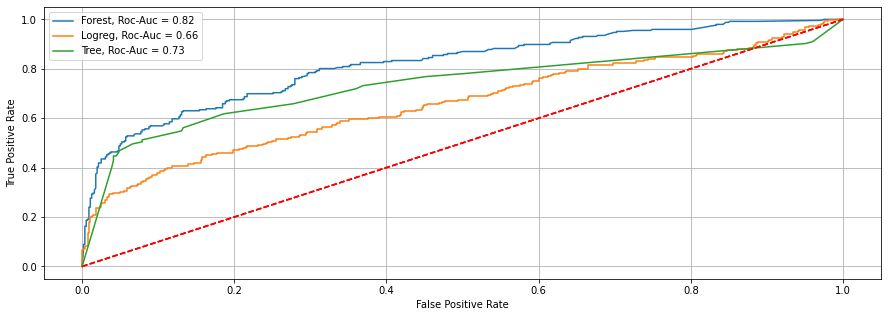

In [27]:
plt.figure(figsize=(15, 5))
appropriate(final_forest_model, features_test, target_test, 'Forest')
appropriate(final_logreg_model, features_test, target_test, 'Logreg')
appropriate(final_tree_model, features_test, target_test, 'Tree')
plt.legend()

По сравнению с рандомной моделью, избранная мной ведет себя более адекватно. Да и по сравнению с остальными тоже.

# Вывод

Одно дерево хорошо, а много - лучше. Но много деревьев - это очень долго, а одно - быстро.  
Логистическая регрессия совсем плохо себя показала - видимо, без фича инжиниринга не обойтись. Хотя решает она достаточно быстро. Можно сказать, молниеносно. Компромисс между скоростью и результатом - дерево решений. Но мой выбор - рандомный лес. 